In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle


#.py
from core import prices as pr

# Replication of the paper's results

## Step 1: What are the results after 10e6 iterations ?

In [5]:
# Path to the pickle file
pickle_file_path = '/Volumes/OS-Data/Suzie_data/RLandPricing/data/data_rep.pkl'

# Open the file in binary read mode
with open(pickle_file_path, 'rb') as file:
    aggregated_agents = pickle.load(file)

# Now, "aggregated_agents" contains the object saved in the pickle file
print(aggregated_agents)

[array([[[0.35609251, 0.31741696],
        [0.31801057, 0.35613313],
        [0.30253787, 0.25121216],
        ...,
        [0.12374889, 0.35742997],
        [0.23497877, 0.21795539],
        [0.27844426, 0.39100528]],

       [[0.34355771, 0.27960543],
        [0.37294167, 0.29794032],
        [0.29202387, 0.36248322],
        ...,
        [0.23970425, 0.28623713],
        [0.2774723 , 0.38740429],
        [0.30349387, 0.30349387]],

       [[0.12374889, 0.35742997],
        [0.32384622, 0.29256439],
        [0.35609251, 0.31741696],
        ...,
        [0.39868283, 0.19274082],
        [0.38465918, 0.20785625],
        [0.25121216, 0.30253787]],

       ...,

       [[0.40422786, 0.13026227],
        [0.4126143 , 0.21612698],
        [0.26868653, 0.24643534],
        ...,
        [0.30793852, 0.3426892 ],
        [0.28446606, 0.17307211],
        [0.20785625, 0.38465918]],

       [[0.15243143, 0.30602215],
        [0.35284496, 0.21608923],
        [0.35284496, 0.21608923],
        

/var/folders/1v/lw80nwsd61d7sp0q_pzj0ppm0000gp/T/ipykernel_864/2331299621.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Volumes/OS-Data/Suzie_data/RLandPricing/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


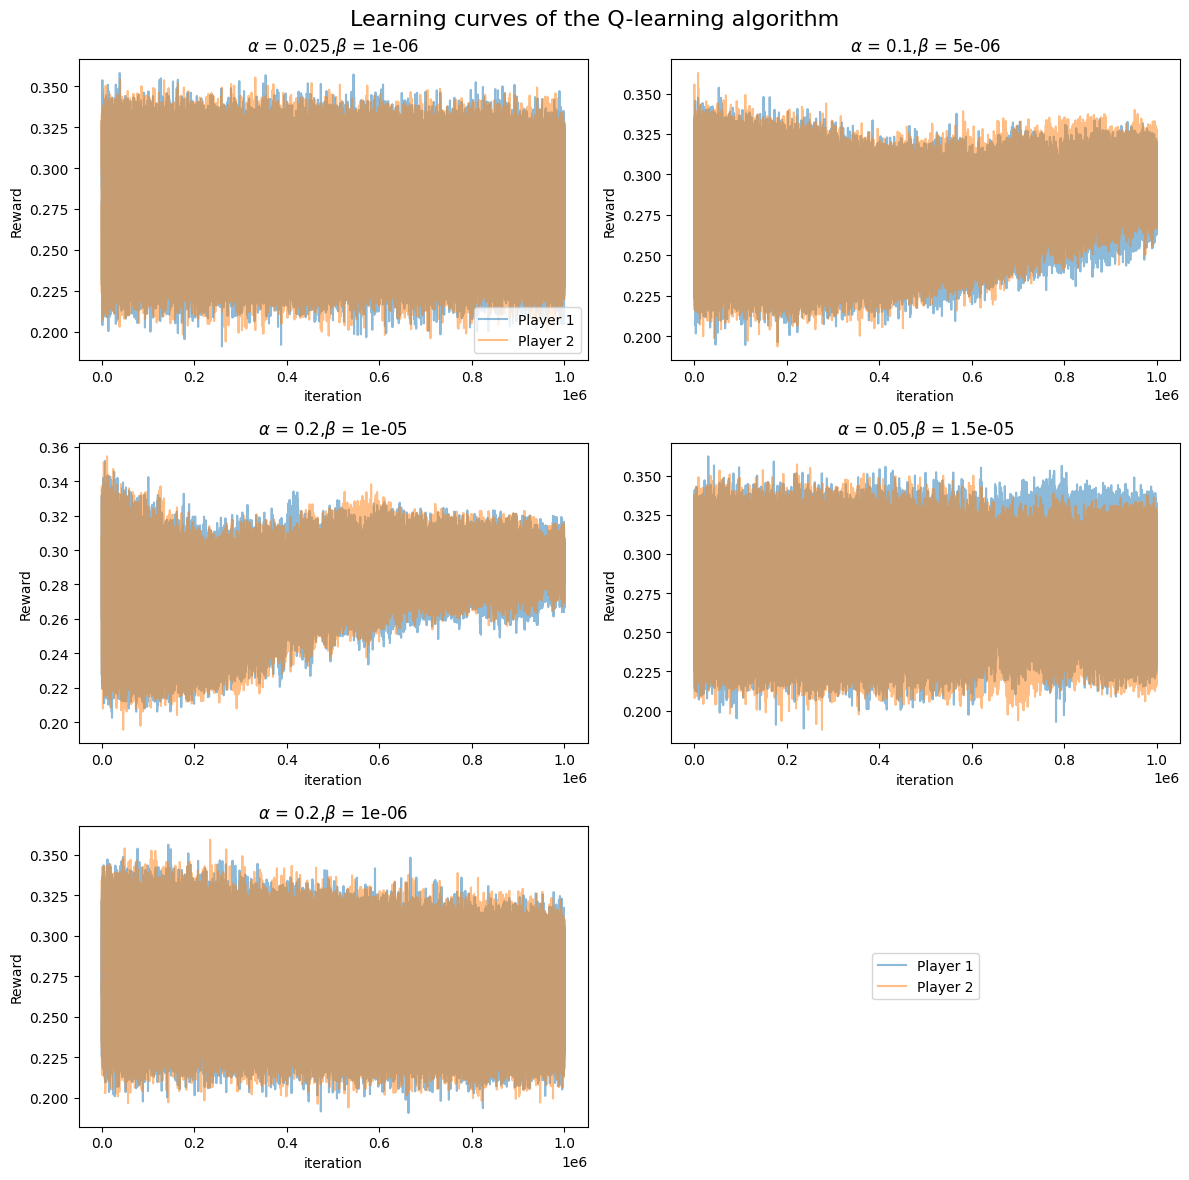

In [6]:
agg = np.array(aggregated_agents).mean(axis=1)
num_players = 2
num_graphs = len(agg)
rep = [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(agg[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(agg[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\alpha$ = {rep[graph_num][0]},$\\beta$ = {round(rep[graph_num][1],8)}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend()

# Remove any unused subplots
if num_graphs < 5:
    for i in range(num_graphs, 5):
        fig.delaxes(axes[i])

# Create a legend in the last subplot
legend_ax = axes[-1]
legend_ax.axis('off')

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Create the legend in the last subplot
legend_ax.legend(handles, labels, loc='center')


fig.suptitle('Learning curves of the Q-learning algorithm', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

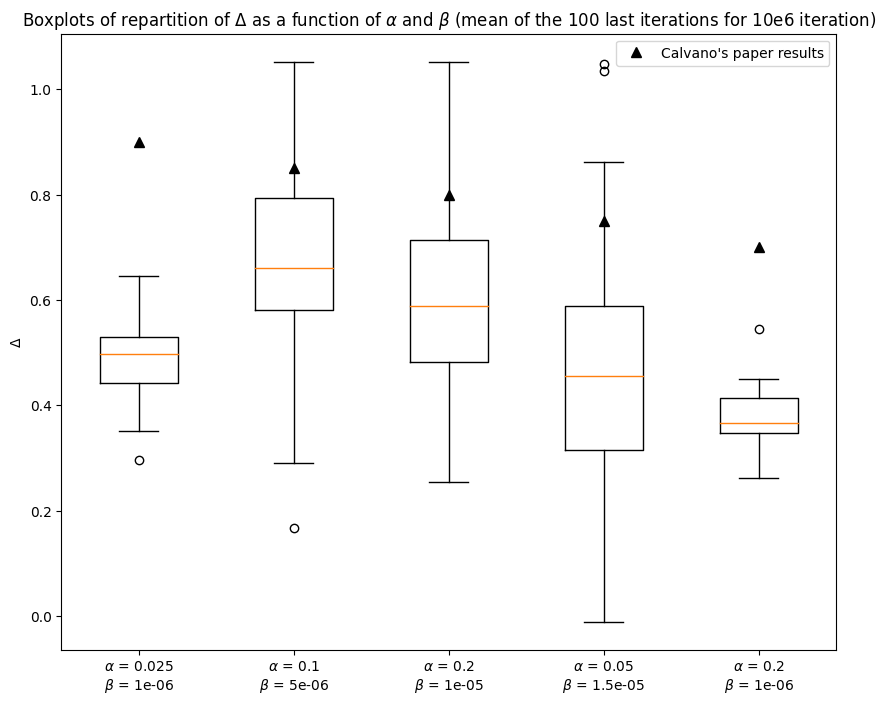

In [7]:

rep = [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()

RN = nash_profit
RC = collusion_profit

    
Rmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0])))
DRmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0]))) 
box = np.zeros((len(aggregated_agents), 2*len(aggregated_agents[0])))

# Parameters
n_params = len(aggregated_agents)

# Loop through each parameter  
for param_ind in range(n_params):

  # Loop through each sample
  for sample_ind in range(len(aggregated_agents[0])):
    for j in range (2):
      Rmean[param_ind][sample_ind][j] = aggregated_agents[param_ind][sample_ind][-100:,j].mean()
      DRmean[param_ind][sample_ind][j] = (Rmean[param_ind][sample_ind][j] - RN)/(RC - RN) 
  box[param_ind] = DRmean[param_ind].reshape(2*len(aggregated_agents[0]))
      

# Mettre les données dans une liste
data = [box[param_ind] for param_ind in range(len(aggregated_agents))]

fig, ax = plt.subplots(figsize=(10, 8))

# Tracer les boxplots
ax.boxplot(data, 
           notch=False, 
           positions=[1,2,3,4,5]) 

# Personnaliser les axes
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([f'$\\alpha$ = {rep[graph_num][0]}\n$\\beta$ = {round(rep[graph_num][1],8)}' for graph_num 
         in range(len(rep))])

ax.set_ylabel('$\\Delta$')

#Calvano's results
h1 = ax.plot(1, 0.9, 'k^', markersize=7)  
handle = h1
leg = ["Calvano's paper results"]
ax.plot(2, 0.85, 'k^', markersize=7)  
ax.plot(3, 0.8, 'k^', markersize=7)
ax.plot(4, 0.75, 'k^', markersize=7)
ax.plot(5, 0.7, 'k^', markersize=7)


plt.legend(handle, leg)
# Ajouter un titre
plt.title('Boxplots of repartition of $\\Delta$ as a function of $\\alpha$ and $\\beta$ (mean of the 100 last iterations for 10e6 iteration)')

plt.show()

/Volumes/OS-Data/Suzie_data/RLandPricing/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


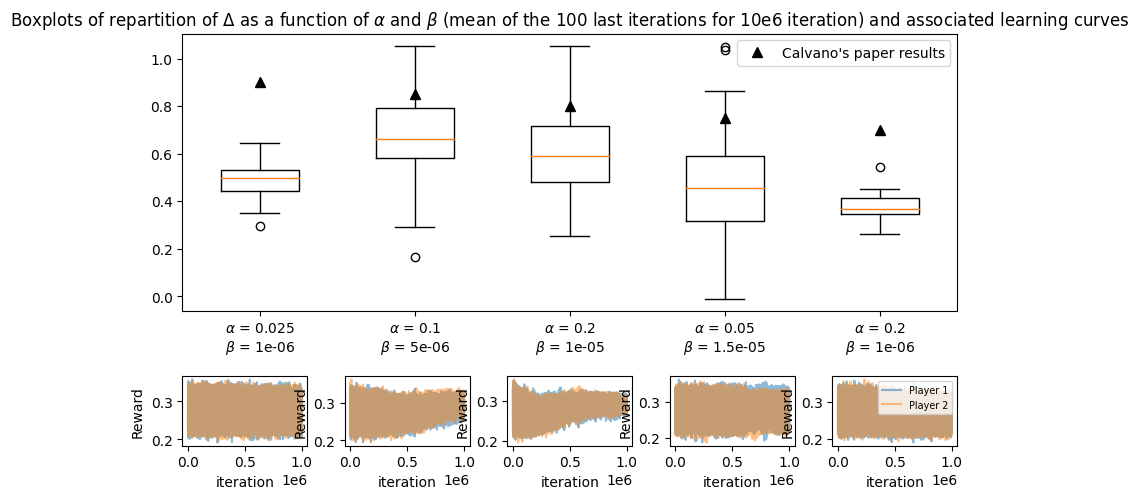

In [5]:
#data for boxplot
rep = [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]

prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()


RN = nash_profit
RC = collusion_profit

    
Rmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0])))
DRmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0]))) 
box = np.zeros((len(aggregated_agents), 2*len(aggregated_agents[0])))

# Parameters
n_params = len(aggregated_agents)

# Loop through each parameter  
for param_ind in range(n_params):

  # Loop through each sample
  for sample_ind in range(len(aggregated_agents[0])):
    for j in range (2):
      Rmean[param_ind][sample_ind][j] = aggregated_agents[param_ind][sample_ind][-100:,j].mean()
      DRmean[param_ind][sample_ind][j] = (Rmean[param_ind][sample_ind][j] - RN)/(RC - RN) 
  box[param_ind] = DRmean[param_ind].reshape(2*len(aggregated_agents[0]))
      

# Mettre les données dans une liste
data_box = [box[param_ind] for param_ind in range(len(aggregated_agents))]

# personnalized figure
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 5, figure=fig, height_ratios=[1, 0.25, 0.5])

# Tracer le graphique principal en haut
ax_box = fig.add_subplot(gs[0, :])
ax_box.boxplot(data_box)
ax_box.set_xticks([1,2,3,4,5])
ax_box.set_xticklabels([f'$\\alpha$ = {rep[graph_num][0]}\n$\\beta$ = {round(rep[graph_num][1],8)}' for graph_num 
         in range(len(rep))])
ax_box.set_title('Boxplots of repartition of $\\Delta$ as a function of $\\alpha$ and $\\beta$ (mean of the 100 last iterations for 10e6 iteration) and associated learning curves')


#Calvano's results
h1 = ax_box.plot(1, 0.9, 'k^', markersize=7)  
handle = h1
leg = ["Calvano's paper results"]
ax_box.plot(2, 0.85, 'k^', markersize=7)  
ax_box.plot(3, 0.8, 'k^', markersize=7)
ax_box.plot(4, 0.75, 'k^', markersize=7)
ax_box.plot(5, 0.7, 'k^', markersize=7)

ax_box.legend(handle, leg)
# Tracer les petits graphiques en bas


#data for learning curves
agg = np.array(aggregated_agents).mean(axis=1)
num_graphs = len(agg)


# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax_lc = fig.add_subplot(gs[1, graph_num])
    ax_lc.set_xlabel('iteration')
    ax_lc.set_ylabel('Reward')
    num_players = len(agg[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
      ax_lc.plot(agg[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
  
        


    
ax_lc.legend(fontsize='x-small')
        

# Ajuster l'espacement entre les sous-graphiques
gs.update(hspace=0.4, wspace=0.3)

# Afficher la figure
plt.show()


## Final state as the paper: if for each player i and each state s the action $a_{i,t}(s) = argmax[Q_{i,t}(a,s)]$ stays constant for 100,000 repetitions. 
### Remark : In reality this is a lake of sens because the algorithm don't keep the historic so it can't know when it stopped the exploration phase 

In [8]:
# Path to the pickle file
pickle_file_path = '/Volumes/OS-Data/Suzie_data/RLandPricing/data/lc_rep_cv.pkl'

# Open the file in binary read mode
with open(pickle_file_path, 'rb') as file:
    agg = pickle.load(file)

# Now, "aggregated_agents" contains the object saved in the pickle file
print(agg)

[[[0.28001699 0.28536141]
  [0.28773667 0.27293571]
  [0.32054127 0.24752962]
  ...
  [0.30409702 0.29632476]
  [0.29465104 0.31637039]
  [0.31543392 0.29590116]]

 [[0.27401294 0.29600228]
  [0.27322162 0.2903456 ]
  [0.26357134 0.27792147]
  ...
  [0.30585597 0.30038018]
  [0.30585597 0.30038018]
  [0.30585597 0.30038018]]

 [[0.27278786 0.28349095]
  [0.26881283 0.30168599]
  [0.27293009 0.29429548]
  ...
  [0.28350132 0.30027524]
  [0.28350132 0.30027524]
  [0.28350132 0.30027524]]

 [[0.29567725 0.26404552]
  [0.29501186 0.24248621]
  [0.2882767  0.24199945]
  ...
  [0.25181637 0.31579436]
  [0.25181637 0.31579436]
  [0.25181637 0.31579436]]

 [[0.28830175 0.26523231]
  [0.2825267  0.29167789]
  [0.25370849 0.28499518]
  ...
  [0.29917022 0.28527131]
  [0.28784784 0.28891095]
  [0.28660974 0.30217877]]]


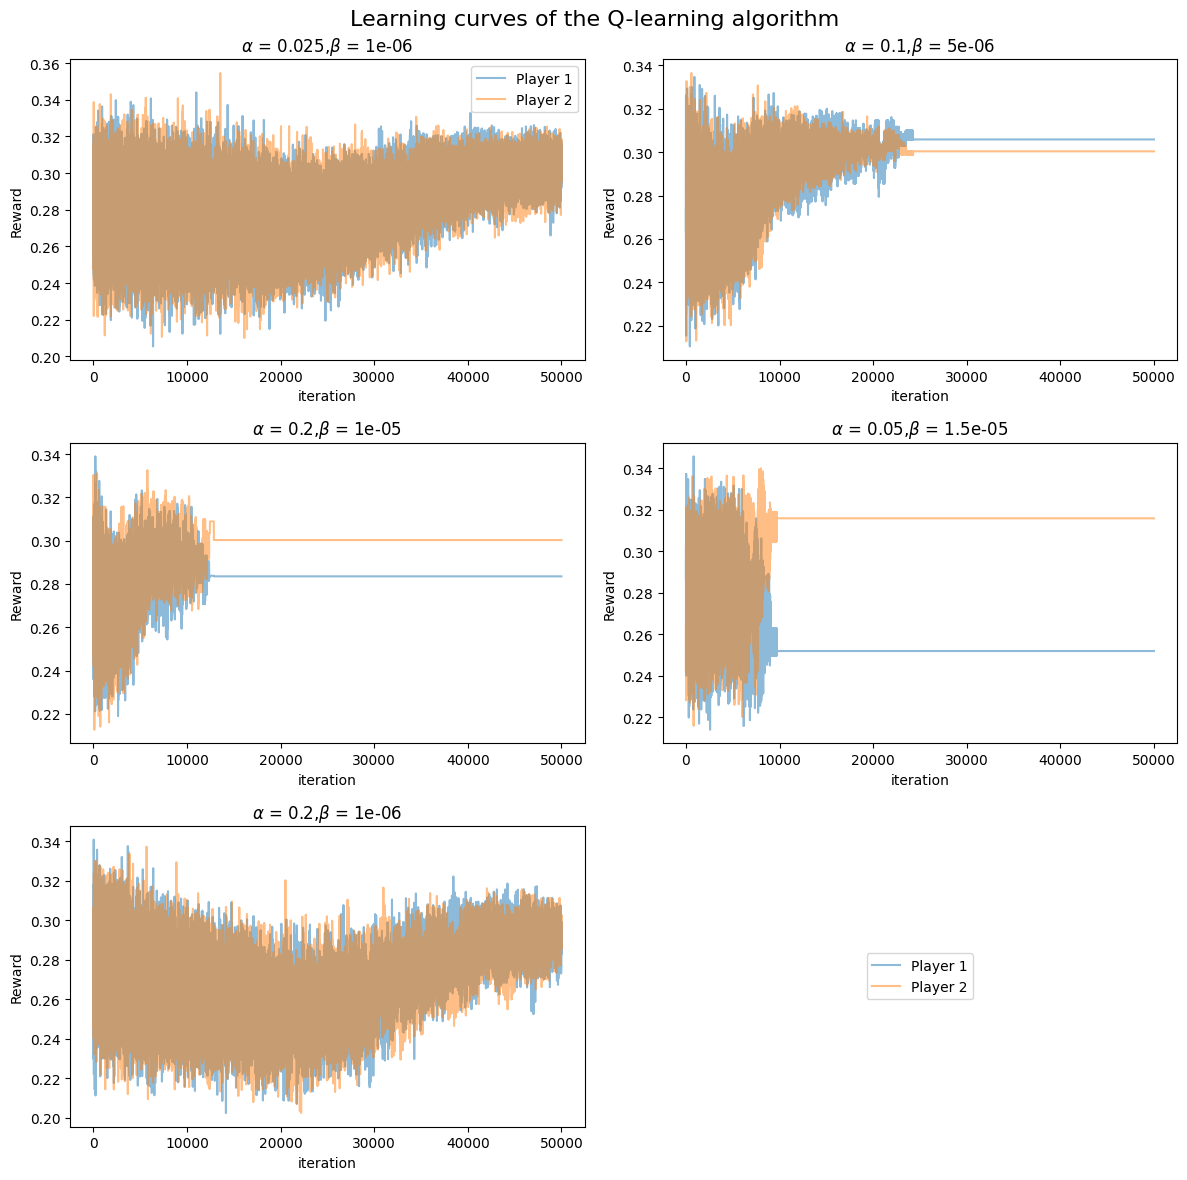

In [9]:
import matplotlib.pyplot as plt
num_players = 2
num_graphs = len(agg)
rep = [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(agg[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(agg[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\alpha$ = {rep[graph_num][0]},$\\beta$ = {round(rep[graph_num][1],8)}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend()

# Remove any unused subplots
if num_graphs < 5:
    for i in range(num_graphs, 5):
        fig.delaxes(axes[i])

# Create a legend in the last subplot
legend_ax = axes[-1]
legend_ax.axis('off')

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Create the legend in the last subplot
legend_ax.legend(handles, labels, loc='center')


fig.suptitle('Learning curves of the Q-learning algorithm', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [10]:
# Path to the pickle file
pickle_file_path = '/Volumes/OS-Data/Suzie_data/RLandPricing/data/final_rep_cv.pkl'

# Open the file in binary read mode
with open(pickle_file_path, 'rb') as file:
    final_rewards = pickle.load(file)

# Now, "aggregated_agents" contains the object saved in the pickle file
print(final_rewards)

[[[[0.22006659 0.28502892]
   [0.38529321 0.1559866 ]
   [0.30318062 0.23089762]
   ...
   [0.3010206  0.33414345]
   [0.32384622 0.29256439]
   [0.3010206  0.33414345]]

  [[0.3221293  0.3221293 ]
   [0.31197786 0.28272627]
   [0.3221293  0.3221293 ]
   ...
   [0.31197786 0.28272627]
   [0.3221293  0.3221293 ]
   [0.31197786 0.28272627]]

  [[0.28656122 0.35398964]
   [0.31764339 0.26178844]
   [0.28656122 0.35398964]
   ...
   [0.31764339 0.26178844]
   [0.28656122 0.35398964]
   [0.31764339 0.26178844]]

  ...

  [[0.31359405 0.31359405]
   [0.31359405 0.31359405]
   [0.31359405 0.31359405]
   ...
   [0.31359405 0.31359405]
   [0.31359405 0.31359405]
   [0.31359405 0.31359405]]

  [[0.33137851 0.27129972]
   [0.28656122 0.35398964]
   [0.33699279 0.22909022]
   ...
   [0.352927   0.1642367 ]
   [0.33462698 0.20864308]
   [0.23497877 0.21795539]]

  [[0.31359405 0.31359405]
   [0.31359405 0.31359405]
   [0.31359405 0.31359405]
   ...
   [0.31359405 0.31359405]
   [0.31359405 0.313594

In [11]:
aggregated_agents = final_rewards

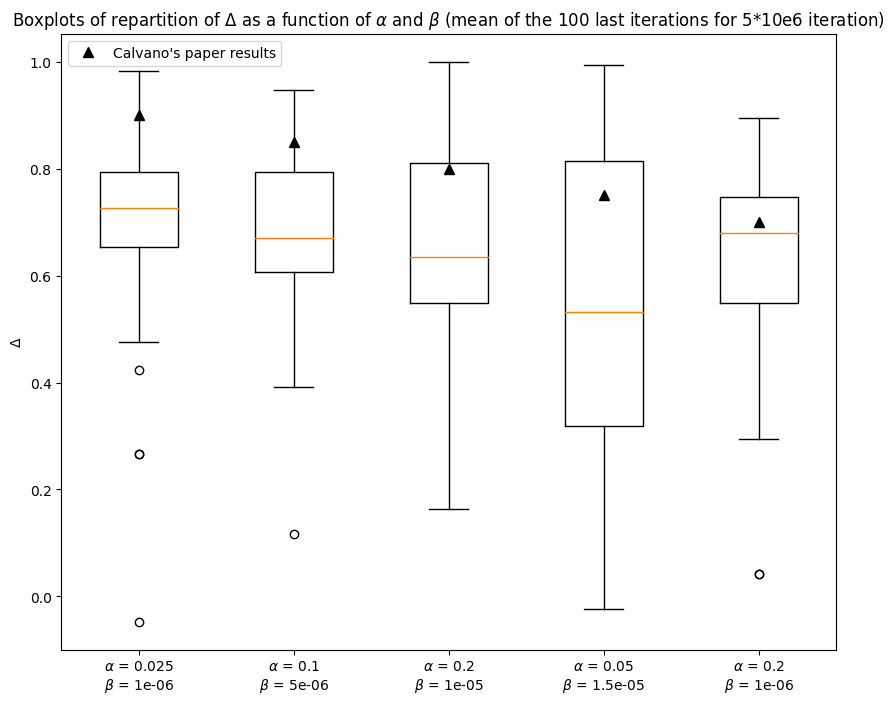

In [12]:
import core.prices as pr
import matplotlib.pyplot as plt

rep = [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()

RN = nash_profit
RC = collusion_profit

    
Rmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0])))
DRmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0]))) 
box = np.zeros((len(aggregated_agents), 2*len(aggregated_agents[0])))

# Parameters
n_params = len(aggregated_agents)

# Loop through each parameter  
for param_ind in range(n_params):

  # Loop through each sample
  for sample_ind in range(len(aggregated_agents[0])):
    for j in range (2):
      Rmean[param_ind][sample_ind][j] = aggregated_agents[param_ind][sample_ind][j,:].mean(axis=0)
      DRmean[param_ind][sample_ind][j] = (Rmean[param_ind][sample_ind][j] - RN)/(RC - RN) 
  box[param_ind] = DRmean[param_ind].reshape(2*len(aggregated_agents[0]))
      

# Mettre les données dans une liste
data = [box[param_ind] for param_ind in range(len(aggregated_agents))]

fig, ax = plt.subplots(figsize=(10, 8))

# Tracer les boxplots
ax.boxplot(data, 
           notch=False, 
           positions=[1,2,3,4,5]) 

# Personnaliser les axes
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([f'$\\alpha$ = {rep[graph_num][0]}\n$\\beta$ = {round(rep[graph_num][1],8)}' for graph_num 
         in range(len(rep))])

ax.set_ylabel('$\\Delta$')

#Calvano's results
h1 = ax.plot(1, 0.9, 'k^', markersize=7)  
handle = h1
leg = ["Calvano's paper results"]
ax.plot(2, 0.85, 'k^', markersize=7)  
ax.plot(3, 0.8, 'k^', markersize=7)
ax.plot(4, 0.75, 'k^', markersize=7)
ax.plot(5, 0.7, 'k^', markersize=7)


plt.legend(handle, leg)
# Ajouter un titre
plt.title('Boxplots of repartition of $\\Delta$ as a function of $\\alpha$ and $\\beta$ (mean of the 100 last iterations for 5*10e6 iteration)')

plt.show()

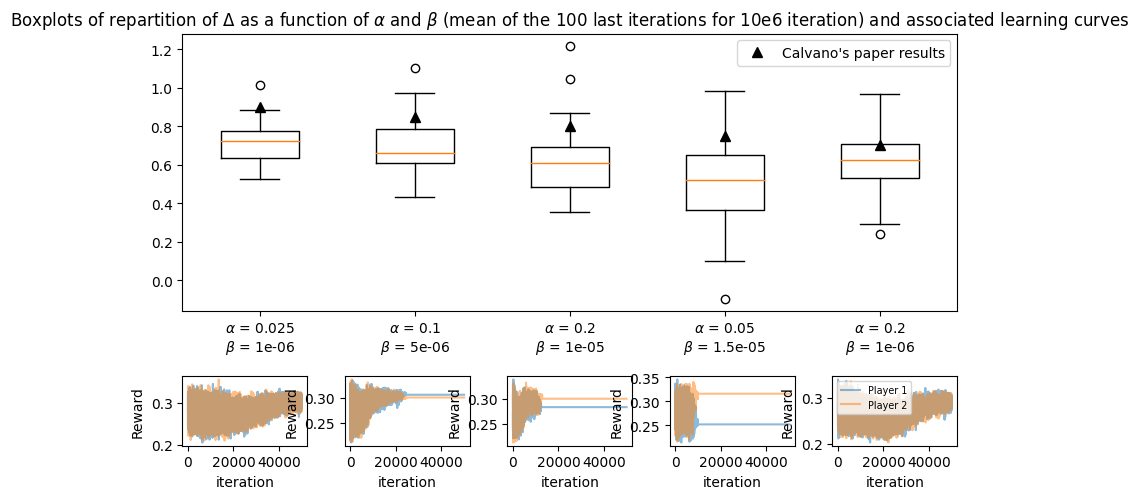

In [13]:
#data for boxplot
rep = [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]

prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()


RN = nash_profit
RC = collusion_profit

    
Rmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0])))
DRmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0]))) 
box = np.zeros((len(aggregated_agents), 2*len(aggregated_agents[0])))

# Parameters
n_params = len(aggregated_agents)

# Loop through each parameter  
for param_ind in range(n_params):

  # Loop through each sample
  for sample_ind in range(len(aggregated_agents[0])):
    for j in range (2):
      Rmean[param_ind][sample_ind][j] = aggregated_agents[param_ind][sample_ind][-100:,j].mean()
      DRmean[param_ind][sample_ind][j] = (Rmean[param_ind][sample_ind][j] - RN)/(RC - RN) 
  box[param_ind] = DRmean[param_ind].reshape(2*len(aggregated_agents[0]))
      

# Mettre les données dans une liste
data_box = [box[param_ind] for param_ind in range(len(aggregated_agents))]

# personnalized figure
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 5, figure=fig, height_ratios=[1, 0.25, 0.5])

# Tracer le graphique principal en haut
ax_box = fig.add_subplot(gs[0, :])
ax_box.boxplot(data_box)
ax_box.set_xticks([1,2,3,4,5])
ax_box.set_xticklabels([f'$\\alpha$ = {rep[graph_num][0]}\n$\\beta$ = {round(rep[graph_num][1],8)}' for graph_num 
         in range(len(rep))])
ax_box.set_title('Boxplots of repartition of $\\Delta$ as a function of $\\alpha$ and $\\beta$ (mean of the 100 last iterations for 10e6 iteration) and associated learning curves')


#Calvano's results
h1 = ax_box.plot(1, 0.9, 'k^', markersize=7)  
handle = h1
leg = ["Calvano's paper results"]
ax_box.plot(2, 0.85, 'k^', markersize=7)  
ax_box.plot(3, 0.8, 'k^', markersize=7)
ax_box.plot(4, 0.75, 'k^', markersize=7)
ax_box.plot(5, 0.7, 'k^', markersize=7)

ax_box.legend(handle, leg)
# Tracer les petits graphiques en bas


#data for learning curves
num_graphs = len(agg)


# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax_lc = fig.add_subplot(gs[1, graph_num])
    ax_lc.set_xlabel('iteration')
    ax_lc.set_ylabel('Reward')
    num_players = len(agg[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
      ax_lc.plot(agg[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
  
        


    
ax_lc.legend(fontsize='x-small')
        

# Ajuster l'espacement entre les sous-graphiques
gs.update(hspace=0.4, wspace=0.3)

# Afficher la figure
plt.show()